In [24]:
from pathlib import Path
import pandas as pd
import gc
from sklearn.preprocessing import LabelEncoder
import pickle
import bz2

from matplotlib import pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib as mpl
%matplotlib inline

In [2]:
data_path = Path('./data/').resolve()
!ls {data_path}

09_groups.csv      10_groups.csv      11_groups.csv      product_groups.csv


In [3]:
g_9 = pd.read_csv('./data/09_groups.csv')
g_9.head()

,date,id_doc,id_order,id_card,id_tov,id_kontr,quantity,sum,is_green,id_group
0,2020-09-01 17:01:25,1283228,0.0,1538855,52,271,1.0,108.00,0,10004
1,2020-09-01 17:35:36,8873113,0.0,267307,52,271,1.0,108.00,0,10004
2,2020-09-01 19:19:21,12712899,0.0,610220,52,271,1.0,107.95,0,10004
3,2020-09-01 21:53:34,21535283,0.0,441497,52,271,1.0,108.00,0,10004
4,2020-09-01 18:42:31,642341,0.0,1065358,61,97,2.0,88.00,0,10091


In [4]:
g_10 = pd.read_csv('./data/10_groups.csv')
g_10.head()

,date,id_doc,id_order,id_card,id_tov,id_kontr,quantity,sum,is_green,id_group
0,2020-10-01 20:22:55,2035558,0.0,1636749,52,339,1.0,107.90,0,10004
1,2020-10-01 20:54:12,13037327,0.0,267261,52,339,1.0,80.04,0,10004
2,2020-10-01 21:25:59,1430590,0.0,1331395,61,379,1.0,31.92,1,10091
3,2020-10-01 13:31:01,3504660,0.0,641525,61,97,1.0,55.98,0,10091
4,2020-10-01 16:32:06,11024438,0.0,1325852,61,97,4.0,176.00,0,10091


In [5]:
g_11 = pd.read_csv('./data/11_groups.csv')
g_11.head()

,date,id_doc,id_order,id_card,id_tov,id_kontr,quantity,sum,is_green,id_group
0,2020-11-01 15:29:01,3121751,0.0,332351,52,271,1.0,107.98,0,10004
1,2020-11-01 12:41:10,22047017,8293317.0,1875438,52,-9999,1.0,108.00,0,10004
2,2020-11-01 13:17:09,6419825,0.0,563112,61,379,2.0,112.00,0,10091
3,2020-11-01 12:31:31,10284541,0.0,1841710,61,379,1.0,55.91,0,10091
4,2020-11-01 13:06:15,10424967,0.0,1304277,61,271,2.0,87.80,0,10091


In [6]:
p_g = pd.read_csv('./data/product_groups.csv', delimiter=';', encoding='windows-1251')
p_g.head()

,id_tov,id_group,name_group
0,52,10004,Кисломолочные продукты
1,75,10004,Кисломолочные продукты
2,77,10004,Кисломолочные продукты
3,143,10004,Кисломолочные продукты
4,151,10004,Кисломолочные продукты


In [8]:
df = pd.concat([g_9, g_10, g_11])

In [12]:
outlier_ids = pd.read_csv('data/bad_ids - bad_ids.csv.csv')['id_card'].values

In [14]:
df = df[~df['id_card'].isin(outlier_ids)]

## Task 1

Prove that buying discounted products depends on the average order sum. (It is more probable that the discounted product will be bought if bunch of money is going to be spend)

### Solution
Define H0 as the following: buying discounted products does not depend on the average order sum

In [20]:
from scipy.stats import ttest_ind

In [16]:
id2avg_sum = df.groupby('id_doc')['sum'].mean()

In [17]:
id2green_cnt = df.groupby("id_doc")['is_green'].sum()

In [18]:
green_buyers = id2green_cnt.index[id2green_cnt.to_numpy().nonzero()]
nongreen_buyers = list(set(id2green_cnt.index).difference(green_buyers))

In [21]:
ttest_ind(id2avg_sum[green_buyers], id2avg_sum[nongreen_buyers])

Ttest_indResult(statistic=-635.9313209809698, pvalue=0.0)

Based on the results of t-test the null hypothesis is rejected. Average order sum and the number of discounted products are dependent.

## Task 2
Prove that the frequency of shopping grows around the wage taking days.

In [22]:
df.index = pd.to_datetime(df['date'],format='%Y-%m-%d %H:%M:%S')

In [23]:
buys_per_day = df.groupby(by=[df.index.day])['id_doc'].count()

<AxesSubplot:xlabel='date'>

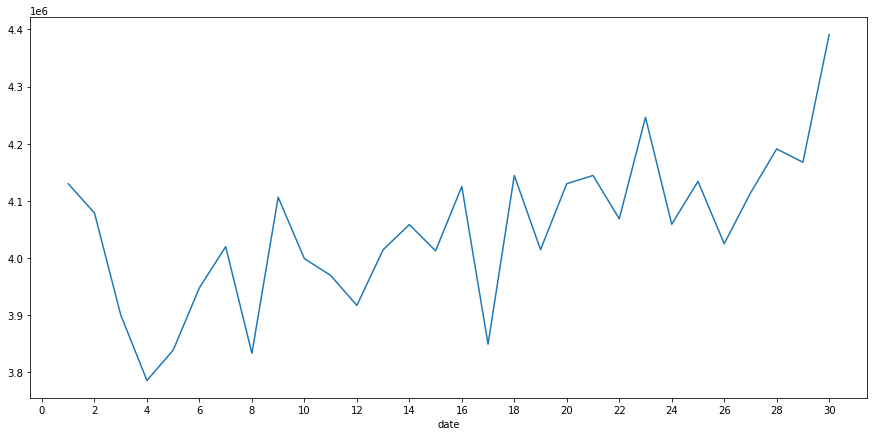

In [39]:
plt.figure(figsize=(15,7))
plt.locator_params(axis="x", nbins=30)
buys_per_day.iloc[:30].plot()

We can see that the frequency of shopping does not increase on the days 1-5 of month, and on the days 20-26 it also does not grow

## Task 3
Define such cohort existance:
1. Frequent buyers - The users that are shopping frequently(daily, weekly, monthly) 
2. Average purchase sum - The customers that usually spend the same amount of money 
3. Orders amount - The customers grouped by the total numer of orders 
4. Usual cart - The customers grouped by the product groups

References
- https://towardsdatascience.com/a-step-by-step-introduction-to-cohort-analysis-in-python-a2cbbd8460ea

### Solution

4. Usual cart

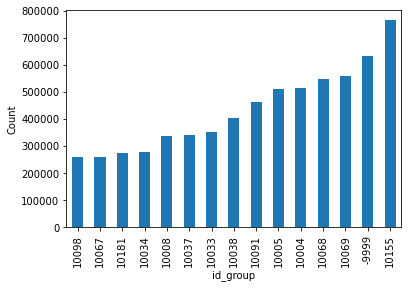

In [9]:
group2num_customers = df.groupby('id_group')['id_card'].unique().apply(len)
group2num_customers.sort_values()[-15:].plot(kind='bar')
plt.ylabel('Count');

We can clearly see cohorts for product groups, it means the exist